In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model_save_dir = "/content/drive/My Drive/my_keras_models/sar_ship_detect_models/"

# Create the directory if it doesn't exist
# exist_ok=True prevents error if directory already exists
os.makedirs(model_save_dir, exist_ok=True)

model_filepath = os.path.join(model_save_dir, "models")

print(f"Model filepath for saving new models: {model_filepath}")

Model filepath for saving new models: /content/drive/My Drive/my_keras_models/sar_ship_detect_models/models


In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!unrar x "/content/drive/My Drive/Colab Notebooks/Datasets/SSDD_coco.rar" "/content/drive/My Drive/ColabNotebooks/Datasets/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/Colab Notebooks/Datasets/SSDD_coco.rar


Would you like to replace the existing file /content/drive/My Drive/ColabNotebooks/Datasets/SSDD_coco/000001.jpg
 14485 bytes, modified on 2017-03-23 12:58
with a new one
 14485 bytes, modified on 2017-03-23 12:58

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [4]:
data_folder = "/content/drive/My Drive/ColabNotebooks/Datasets/SSDD_coco/"

img_num = 0
json_num = 0

CATEGORIES = os.listdir(data_folder)
for cat in CATEGORIES:
  if cat.endswith('.json'):
    json_num += 1
  else:
    img_num += 1

print(f"number of images: {img_num}")
print(f"number of corresponding JSON data: {json_num}")

number of images: 1160
number of corresponding JSON data: 1160


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # --- Encoder (Contracting Path) ---
    # Block 1: 32 filters
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Block 2: 64 filters
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Block 3: 128 filters
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Block 4: 256 filters
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # --- Bottleneck: 512 filters ---
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Decoder (Expansive Path) ---
    # Block 6: 256 filters
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5) # Upsample to match c4 spatial dims
    u6 = layers.concatenate([u6, c4], axis=-1) # Skip Connection from c4 (256 filters)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7: 128 filters
    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6) # Upsample to match c3 spatial dims
    u7 = layers.concatenate([u7, c3], axis=-1) # Skip Connection from c3 (128 filters)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8: 64 filters
    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7) # Upsample to match c2 spatial dims
    u8 = layers.concatenate([u8, c2], axis=-1) # Skip Connection from c2 (64 filters)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9: 32 filters
    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8) # Upsample to match c1 spatial dims
    u9 = layers.concatenate([u9, c1], axis=-1) # Skip Connection from c1 (32 filters)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output Layer ---
    # 1x1 Convolution to map features to the single output channel (ship probability)
    # Use 'sigmoid' activation for binary (0 or 1) segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # --- Create Model ---
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# --- Instantiate and Compile the Model ---

# Define the input shape
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Build the U-Net model
unet_model = build_unet(input_shape)

# Compile the model
# Use 'binary_crossentropy' for sigmoid output and masks with 0s and 1s.
unet_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy']) # 'accuracy' here is pixel-wise accuracy

# Print the model summary
print("Defined U-Net model architecture:")
unet_model.summary()

Defined U-Net model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
print("Loading in data...")

data_files = []

image_files = sorted(tf.io.gfile.glob(os.path.join(data_folder, '*.jpg')))
json_files = sorted(tf.io.gfile.glob(os.path.join(data_folder, '*.json')))

print(f"Found {len(image_files)} JPEG image files.")
print(f"Found {len(json_files)} JSON files.")

json_dict = {os.path.splitext(os.path.basename(_file))[0]: _file for _file in json_files}

for img_path in image_files:
    path_name = os.path.splitext(os.path.basename(img_path))[0]
    json_path = json_dict[path_name]
    data_files.append({'image': img_path, 'json': json_path})
    print(f"Appended {os.path.basename(img_path)} with {os.path.basename(json_path)}")

print(f"\nSuccessfully added {len(data_files)} image/json files.")

Loading in data...
Found 1160 JPEG image files.
Found 1160 JSON files.
Appended 000001.jpg with 000001.json
Appended 000002.jpg with 000002.json
Appended 000003.jpg with 000003.json
Appended 000004.jpg with 000004.json
Appended 000005.jpg with 000005.json
Appended 000006.jpg with 000006.json
Appended 000007.jpg with 000007.json
Appended 000008.jpg with 000008.json
Appended 000009.jpg with 000009.json
Appended 000010.jpg with 000010.json
Appended 000011.jpg with 000011.json
Appended 000012.jpg with 000012.json
Appended 000013.jpg with 000013.json
Appended 000014.jpg with 000014.json
Appended 000015.jpg with 000015.json
Appended 000016.jpg with 000016.json
Appended 000017.jpg with 000017.json
Appended 000018.jpg with 000018.json
Appended 000019.jpg with 000019.json
Appended 000020.jpg with 000020.json
Appended 000021.jpg with 000021.json
Appended 000022.jpg with 000022.json
Appended 000023.jpg with 000023.json
Appended 000024.jpg with 000024.json
Appended 000025.jpg with 000025.json
Appe

In [7]:
_image_paths = [data['image'] for data in data_files]
_json_paths = [data['json'] for data in data_files]

from sklearn.model_selection import train_test_split

img_train, img_test, json_train, json_test = train_test_split(_image_paths, _json_paths, test_size=0.2, random_state=42)
print("Splitting data success")

Splitting data success


In [8]:
import json
import numpy as np
import cv2  # Make sure OpenCV is installed: !pip install opencv-python
import os

# Define the target image dimensions (should match your model's expected input/output spatial size)
IMG_HEIGHT = 256
IMG_WIDTH = 256

def create_mask_from_json(json_path, target_dims=(IMG_HEIGHT, IMG_WIDTH)):
    # 1. Initialize an empty mask (background class = 0)
    #    Using uint8 is compatible with cv2.fillPoly and common for masks.
    mask = np.zeros(target_dims, dtype=np.uint8)

    try:
        # 2. Check if JSON file exists
        if not os.path.exists(json_path):
            print(f"Warning: JSON file not found at {json_path}")
            return mask # Return empty mask if JSON doesn't exist

        # 3. Load JSON data
        with open(json_path, 'r') as f:
            annotation_data = json.load(f)

        # 4. Get original image dimensions (needed for scaling coordinates)
        #    These keys might vary ('imageHeight', 'image_height', etc.) - check your JSON!
        original_height = annotation_data.get('imageHeight')
        original_width = annotation_data.get('imageWidth')

        # Basic validation of dimensions
        if original_height is None or original_width is None or original_height <= 0 or original_width <= 0:
             # If original dims aren't available or invalid, we can't scale accurately.
             # We could either raise an error, return empty mask, or try proceeding without scaling
             # (assuming coordinates might already be relative to target_dims, which is risky).
             print(f"Warning: Valid original image dimensions not found or invalid in {json_path}. Cannot create accurate mask.")
             return mask # Return empty mask

        # 5. Calculate scaling factors if target dims differ from original
        scale_y = target_dims[0] / original_height
        scale_x = target_dims[1] / original_width

        # 6. Find the list of annotated shapes (common key is 'shapes')
        #    This key might also vary ('objects', 'annotations', etc.) - check your JSON!
        shapes = annotation_data.get('shapes', [])
        if not shapes:
            # If no shapes are found, the mask remains empty (all background)
            # print(f"Debug: No 'shapes' array found or empty in {json_path}.") # Optional debug print
            pass # Continue, will return the empty mask

        # 7. Iterate through shapes found in the JSON
        for shape in shapes:
            # Check if the label indicates a ship (case-insensitive check)
            label = shape.get('label', '').lower()
            shape_type = shape.get('shape_type', '').lower()

            # Process only if it's a 'ship' and a 'polygon'
            if label.startswith('ship') and shape_type == 'polygon':
                points = shape.get('points', [])
                # Need at least 3 points to form a valid polygon for filling
                if len(points) >= 3:
                    # Scale the polygon points from original dimensions to target dimensions
                    scaled_points = np.array([(p[0] * scale_x, p[1] * scale_y) for p in points], dtype=np.int32)

                    # Draw the filled polygon onto the mask
                    # cv2.fillPoly expects a list of polygons, hence [scaled_points]
                    # It fills the polygon area with the specified color (1 for ship)
                    cv2.fillPoly(mask, [scaled_points], color=(1))
                else:
                     print(f"Warning: Ship polygon with < 3 points found in {json_path}. Skipping this shape.")

    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file: {json_path}")
        return np.zeros(target_dims, dtype=np.uint8) # Return empty mask on parsing error
    except Exception as e:
        # Catch any other unexpected errors during processing
        print(f"An unexpected error occurred processing {json_path}: {e}")
        return np.zeros(target_dims, dtype=np.uint8) # Return empty mask on other errors

    # 8. Return the final mask
    print("Created mask")
    return mask

In [9]:
import tensorflow as tf
import numpy as np
import cv2
import os
import json
import math
from tensorflow.keras import layers, models, Input

# --- Define Constants ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3  # Assuming RGB based on cv2.imread and cvtColor
BATCH_SIZE = 2
EPOCHS = 5

# --- tf.data Loading and Preprocessing Function ---
# This function will be mapped over the dataset of file paths.
def load_and_preprocess(image_path_tensor, json_path_tensor):
    # 1. Define Python wrapper for mask creation (needed for tf.py_function)
    # This function takes the byte tensor from tf.py_function, decodes it,
    # and calls your existing Python mask creation function.
    def _create_mask_py(json_path_bytes):
        json_path = json_path_bytes.numpy().decode('utf-8')
        # Call your existing function to create the mask
        mask_np = create_mask_from_json(json_path, target_dims=(IMG_HEIGHT, IMG_WIDTH))
        # Ensure dtype is float32 for binary_crossentropy loss
        return mask_np.astype(np.float32)

    # 2. Load and preprocess image using TensorFlow ops (more efficient within tf.data)
    img_bytes = tf.io.read_file(image_path_tensor)
    # Use decode_jpeg since original files are .jpg
    img = tf.io.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # Resize using tf.image (ensure size matches mask target_dims and model input)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize
    img = img / 255.0
    # Ensure correct dtype
    img = tf.cast(img, tf.float32)
    # Explicitly setting shape can sometimes help TF optimize
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # 3. Create mask using tf.py_function
    # tf.py_function wraps your Python code so TF can call it during mapping.
    mask = tf.py_function(
        func=_create_mask_py,        # The Python function wrapper to call
        inp=[json_path_tensor],      # Input tensor (the json path)
        Tout=tf.float32              # Expected output data type from the Python function
    )
    # Set shape for the mask tensor (H, W). Crucial for model compatibility!
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH])
    # Add channel dimension -> (H, W, 1), as expected by the U-Net output/loss
    mask = tf.expand_dims(mask, axis=-1)

    # Return the processed image and mask as a tuple
    return img, mask

# --- Create tf.data Datasets ---
print("Creating tf.data datasets...")

# Create datasets from the lists of file paths
# Slices the lists, so each element of the dataset is (image_path_string, json_path_string)
train_ds_raw = tf.data.Dataset.from_tensor_slices((img_train, json_train))
val_ds_raw = tf.data.Dataset.from_tensor_slices((img_test, json_test)) # Use test split for validation

# Use AUTOTUNE for optimal parallel processing and prefetching
AUTOTUNE = tf.data.AUTOTUNE

# --- Build the Training Dataset Pipeline ---
print("Building training pipeline...")
train_dataset = train_ds_raw \
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
    .shuffle(buffer_size=len(img_train)) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE) # Prepares next batches while GPU is busy

# --- Build the Validation Dataset Pipeline ---
print("Building validation pipeline...")
val_dataset = val_ds_raw \
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

print("Datasets created successfully.")
# Verify the output structure, shape, and types of the datasets
print("Training Dataset Element Spec:", train_dataset.element_spec)
print("Validation Dataset Element Spec:", val_dataset.element_spec)


# --- Train the Model using the tf.data Datasets ---
print("\nStarting model training...")

NUM_TRAIN_SAMPLES = len(img_train)
NUM_VAL_SAMPLES = len(img_test) # Using test set as validation set here

# Calculate steps per epoch - important if dataset could repeat indefinitely
# Using math.ceil ensures all samples are seen even if not perfectly divisible
steps_per_epoch = math.ceil(NUM_TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(NUM_VAL_SAMPLES / BATCH_SIZE)

print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Steps per Epoch: {steps_per_epoch}")
print(f"Validation Steps per Epoch: {validation_steps}")

# Now call model.fit with the tf.data.Dataset objects
history = unet_model.fit(
    train_dataset,               # Pass the training dataset object
    epochs=EPOCHS,
    validation_data=val_dataset, # Pass the validation dataset object
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

print("\nModel training finished!")

Creating tf.data datasets...
Building training pipeline...
Building validation pipeline...
Datasets created successfully.
Training Dataset Element Spec: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
Validation Dataset Element Spec: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))

Starting model training...
Epochs: 5
Batch Size: 2
Training Steps per Epoch: 464
Validation Steps per Epoch: 116
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask
Created mask


In [10]:
unet_model.export(model_filepath)
print(f"Model saved to: {model_filepath}")

Saved artifact at '/content/drive/My Drive/my_keras_models/sar_ship_detect_models/models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  139823380775760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823379806544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380778832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380780176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380779024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380781520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380782672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139823380783824: Tens

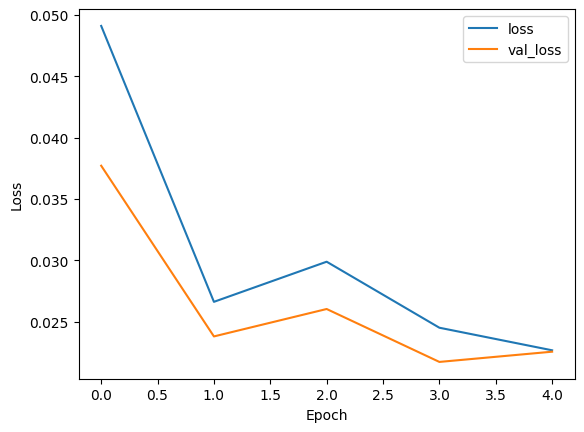

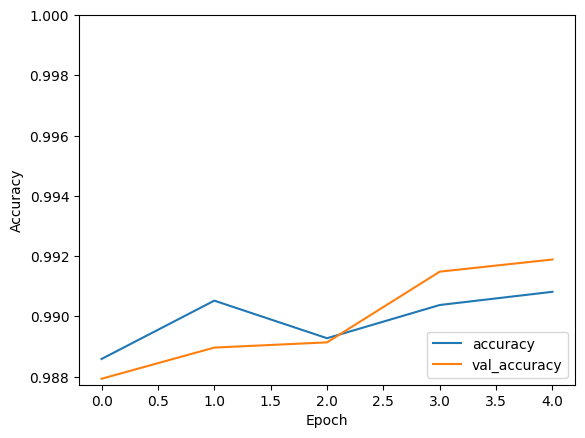

In [11]:
# Optional: Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1]) # Adjust ylim if needed
plt.legend(loc='lower right')
plt.show()

In [12]:
!pip install --upgrade tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [13]:
import tf2onnx
import numpy as np
import os

# Get the tf2onnx installation directory
tf2onnx_dir = os.path.dirname(tf2onnx.__file__)
tfonnx_path = os.path.join(tf2onnx_dir, "tfonnx.py")

print(f"Attempting to patch tf2onnx file at: {tfonnx_path}")

try:
    with open(tfonnx_path, 'r') as f:
        content = f.read()

    # Replace np.cast with np.asarray in the specific function
    updated_content = content.replace("np.cast", "np.asarray")

    with open(tfonnx_path, 'w') as f:
        f.write(updated_content)

    print("Successfully attempted to patch tf2onnx.")

except Exception as e:
    print(f"An error occurred while trying to patch tf2onnx: {e}")

# Now, try the ONNX conversion again
!python -m tf2onnx.convert --saved-model /content/drive/MyDrive/my_keras_models/sar_ship_detect_models/models --output sar_ship_u-net.onnx --opset 15

Attempting to patch tf2onnx file at: /usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py
Successfully attempted to patch tf2onnx.
E0000 00:00:1745397133.811510    4989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745397133.817383    4989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-04-23 08:32:17,809 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
I0000 00:00:1745397137.936901    4989 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 705 